In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException

import time
import re
import datetime as dt

from nltk import FreqDist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sample_username = " "
sample_password = " "
chromedriverpath = '/Users/inika/Selenium Webdrivers/chromedriver'

## Helper Functions

In [2]:
def roundToN(x, base=50): #rounds number up to nearest n (default=50)
    x+=base
    return base * round(x/base)

def login(username,password):
    driver.get('https://instagram.com')
    lg = wait.until(ec.presence_of_element_located((By.XPATH,"//button[@type = 'submit']")))
    inputs = driver.find_elements_by_tag_name('input')
    inputs[0].send_keys(username)
    inputs[1].send_keys(password)
    lg.click()
    time.sleep(3)
    try:
#         driver.find_element_by_xpath("/html/body/div[4]/div/div/div[3]/button[2]").click()
        driver.find_element_by_xpath("//*[contains(text(), 'Not Now')]").click() # to remove notifications dialog
        time.sleep(1)
    except NoSuchElementException:
        pass
    
    
def clearSearch():
    driver.find_element_by_xpath("//div[contains(@class, 'coreSpriteSearchClear')]").click()

def search(term):
    searchbox = driver.find_element_by_xpath("//input[@placeholder = 'Search']") #search box
    searchbox.send_keys(term)
    result = wait.until(ec.presence_of_element_located((By.XPATH,"//div[@class = 'fuqBx']")))
    return list(result.find_elements_by_xpath("./*"))

# def goToProfile(name):
#     res = search("@"+name)
#     profile = res.find_element_by_xpath("./a")
#     driver.get(profile.get_attribute('href'))  

def scroller(n): #scrolls page n times
    scrolls = 0
    current_height = driver.execute_script('return document.body.scrollHeight;') 
    while scrolls < n:
        driver.execute_script('window.scrollTo(0,arguments[0]);',current_height)
        scrolls+=1
        time.sleep(3)
        new_height = driver.execute_script('return document.body.scrollHeight;')
        if new_height==current_height:
            break
        current_height=new_height
    
    
def scrollPosts(n=5): #scrolls no of rows required to reveal n posts
    current_height = driver.execute_script('return document.body.scrollHeight;')
    while(len(driver.find_elements_by_xpath("//div[@class = 'Nnq7C weEfm']")) < round(n/3)): # scroll n/3 rows 
        driver.execute_script('window.scrollBy(0,arguments[0]);', current_height)
        new_height = driver.execute_script('return document.body.scrollHeight;')
        current_height = new_height 
        
        
def cleanString(string):
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',string) #remove links
    string = re.sub('@[^\s]+','',string) #remove usernames
    string = re.sub('\\n',' ',string) #remove newline chars
    string = string.encode('ascii', 'ignore').decode('ascii') #remove emojis
    string = re.sub('[0-9//]+','',string) # remove numbers and /
    string = re.sub('[\s]+[smhdw][\s]+',' ', string) # remove remaining timestamp after numbers have been removed
    string = re.sub('[\s]+', ' ', string) #remove additional whitespaces
    string = string.strip()
    return string

In [3]:
driver = webdriver.Chrome(chromedriverpath)
wait = WebDriverWait(driver, 10) #driver, upper limit
login(sample_username, sample_password)

## Question 1: 

Now your friend has followed a lot of different food bloggers, he needs to analyse the habits of these bloggers.
From the list of instagram handles you obtained when you searched ‘food’ in previous project. 
- Open the first 10 handles and find the top 5 which have the highest number of followers
- Now Find the number of posts these handles have done in the previous 3 days.
- Depict this information using a suitable graph.

In [4]:
results = search("food")
handles = {} # dictionary with handle as key and link as value
n = 10

for i in results:
    result = i.get_attribute('href')
    if 'location' not in result and 'tags' not in result: # so only links to profiles are collected
        x = i.find_element_by_xpath('./div/div/div') # name of handle 
        handles[x.text] = result
        if len(handles)==n:
            break

clearSearch() #clears searchbar
followers = {} #dictionary with handle as key and no of followers as value

for h in handles: #visit each handle and extract no of followers
    driver.get(handles[h])
    followers[h] = int(re.sub("[^0-9]","",driver.find_element_by_xpath("//a[text() = ' followers']/span").get_attribute('title'))) #remove , to convert to int
    if len(followers)==10:
        break

In [5]:
print("Top 5 profiles with highest number of followers: \n")
top5followers = sorted(followers.items(),key=lambda x:x[1],reverse=True)[:5] #sort handles by followers and pick top 5
top5handles = [t[0] for t in top5followers] # list of top 5 handles
follower_counts = np.array([t[1] for t in top5followers]) #their followers

for i,t in enumerate(top5followers):
    print("{}. {}: {} followers".format(i+1,t[0],t[1]))

Top 5 profiles with highest number of followers: 

1. foodnetwork: 10141675 followers
2. foodys: 9619488 followers
3. yourfoodlab: 913036 followers
4. foodtalkindia: 292733 followers
5. foodie_incarnate: 157166 followers


In [6]:
post_freq = {} #tuples as values for every profile as key. tuple contains no of posts made
# in last 3 days as first item and a list of timestamps of each such post as second item
for handle in top5handles: 
    driver.get(handles[handle])
    i=1
    count=0
    done = False #True when a post older than 3days has been found
    visited = []
    timestamps = [] 
    while not done:
        scroller(i) #scrolls 1 time
        posts = list(driver.find_elements_by_xpath("//div[@class = 'v1Nh3 kIKUG  _bz0w']"))
        for p in posts:     
            try:
                link = p.find_element_by_xpath('./a').get_attribute('href')    
            except StaleElementReferenceException:
                driver.execute_script('window.scrollBy(0,arguments[0]);',-1000) #scroll up 1000px if element is no longer on page
                time.sleep(2)
                link = p.find_element_by_xpath('./a').get_attribute('href') #and try finding link again
     
            if link not in visited:
                p.find_element_by_xpath(".//div[@class = 'eLAPa']").click()
                x = wait.until(ec.presence_of_element_located((By.TAG_NAME,"time")))
                x = x.text.lower()
                driver.find_element_by_xpath("//*[@aria-label='Close']").click() 
                visited.append(link)

                if 'h' in x or 'm' in x or 'd' in x:
                    if 'd' in x and int(x[0])>3:
                        done = True
                    else:
                        count+=1
                        timestamps.append(x)
                else:
                    done = True
            if done:
                break
                
        post_freq[handle] = (count,timestamps)
       
                
#     ts = wait.until(ec.presence_of_element_located((By.TAG_NAME,'time'))).get_attribute('datetime')
#     ts = re.sub('[TZ]',' ',timestamp).rstrip().split('.')[0]
#     ts = dt.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
#     d1 = ts.date()
#     d2 = dt.date.today()
#     d = (d2-d1).days
#     driver.back()

### Plots

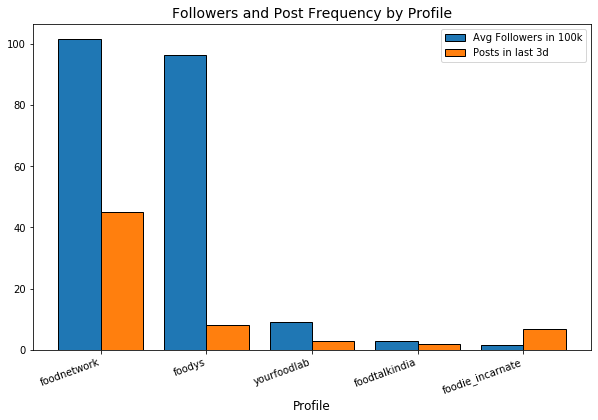

In [7]:
x = np.arange(0,5)
y1 = follower_counts/100000 
y2 = [t[0] for t in post_freq.values()]

plt.figure(figsize=(10,6))
# ax = plt.subplot(111) can use ax.bar
plt.bar(x - 0.4, y1, width=0.4, align='center',edgecolor='k',label='Avg Followers in 100k')
plt.bar(top5handles, y2, width=0.4, color='tab:orange', align='center',edgecolor='k',label='Posts in last 3d')
plt.xticks(x - 0.2,rotation = 20,horizontalalignment='right')
plt.xlabel("Profile",fontsize=12)
plt.title('Followers and Post Frequency by Profile',fontsize=14)
# axes = plt.gca()
# axes.yaxis.grid()
plt.legend()
plt.show()

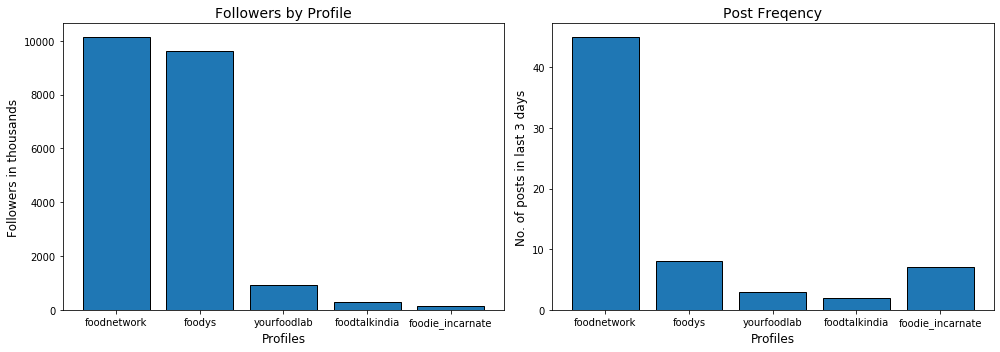

In [8]:
fig,ax = plt.subplots(1,2, figsize=(14,5))
ax[0].bar(top5handles,follower_counts/1000,edgecolor = 'k')
ax[0].set_title("Followers by Profile", fontsize = 14)
ax[0].set_xlabel("Profiles", fontsize = 12)
ax[0].set_ylabel("Followers in thousands", fontsize = 12)

ax[1].bar(top5handles,[t[0] for t in post_freq.values()],edgecolor = 'k')
ax[1].set_title("Post Freqency", fontsize = 14)
ax[1].set_xlabel("Profiles", fontsize = 12)
ax[1].set_ylabel("No. of posts in last 3 days", fontsize = 12)

plt.tight_layout()
plt.show()

## Question 2
Your friend also needs a list of hashtags that he should use in his posts.
- Open the 5 handles you obtained in the last question, and scrape the content of the first 10 posts of each handle.
- Prepare a list of all words used in all the scraped posts and calculate the frequency of each word.
- Create a csv file with two columns : the word and its frequency
- Now, find the hashtags that were most popular among these bloggers
- Plot a Pie Chart of the top 5 hashtags obtained and the number of times they were used by these bloggers in the scraped posts.

In [9]:
n = 10
posts = {} # a dictionary with keys corresponding to profiles with value as a list, each item contains a post as a string

for handle in top5handles:
    hrefs = [] #collecting links for top n posts
    posts[handle] = []
    driver.get(handles[handle])
#     scrollPosts(n) #probably not required for just 10 posts
    p = driver.find_elements_by_xpath("//div[@class = 'v1Nh3 kIKUG  _bz0w']") 
    for post in p:
        link = post.find_element_by_tag_name('a').get_attribute('href')
        hrefs.append(link)
        if len(hrefs)==n:
            break

    for post in hrefs:
        driver.get(post)
        posts[handle].append(driver.find_element_by_xpath("//div[@class = 'C4VMK']").text)    

### Create CSV

In [10]:
# Prepare a list of all words used in all the scraped posts and calculate the frequency of each word.
all_words = ""
for handle in posts:
    posts_list = posts[handle]
    for post in posts_list:
        all_words+=" "+post        

all_words = cleanString(all_words)
words_list = [word for word in re.split(' |, |\. |\? |! |:',all_words) if word!=''] #split string into words using punctuators as separators and remove null strings

fdist = FreqDist(words_list) # to find distribution or frequency of words
#fdist.most_common(50)
word_distribution = dict(fdist) #convert FreqDist object into python dict
word_distribution = {i:[k,word_distribution[k]] for i,k in enumerate(word_distribution)}
df = pd.DataFrame.from_dict(word_distribution,columns=['Word','Frequency'],orient='index') # Create dataframe out of dict

df.to_csv('FrequencyDist.csv',index = False) #create required csv files

### Hashtags

In [11]:
hashtags = {} #dictionary containing hashtags and their frequency
for word in words_list:
    if word[0]=='#':
        hashtags[word]=hashtags.get(word,0)+1

hashtags = sorted(hashtags.items(),key=lambda x: x[1],reverse = True)
print("Popular Hashtags\n----------------------------------")
print("Hashtag".center(15),"No of times used".center(20),"\n----------------------------------")
for t in hashtags:
    if t[1]==1:
        break
    print(t[0].ljust(18),str(t[1]).center(20))    

Popular Hashtags
----------------------------------
    Hashtag       No of times used   
----------------------------------
#foodie                     6          
#DDD                        4          
#staysafe                   3          
#indiancuisine              3          
#quarantinelife             2          
#stayhome                   2          
#indian                     2          
#streetfood                 2          
#SafeHands                  2          
#sanjyotkeer
1w             2          


### Plots

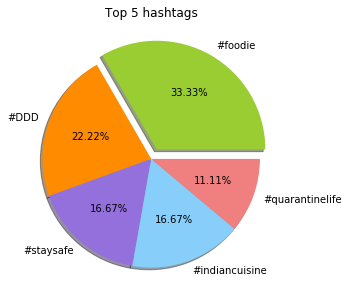

In [12]:
plt.figure(figsize=(5,5))
explode = [0 for i in range(5)]
colors = ['yellowgreen', 'darkorange', 'mediumpurple','lightskyblue','lightcoral','lavenderblush']
explode[np.array([t[1] for t in hashtags]).argmax()]=0.1
plt.title("Top 5 hashtags",fontsize = 12)
plt.pie([t[1]for t in hashtags[:5]], labels = [t[0]for t in hashtags[:5]],autopct="%.2f%%", 
        explode = explode, shadow=True, colors = colors,)
plt.show()

## Question 3
You need to also calculate average followers : likes ratio for the obtained handles. 
Followers : Likes ratio is calculated as follows:
- Find out the likes of the top 10 posts of the 5 handles obtained earlier.
- Calculate the average likes for a handle.
- Divide the average likes obtained from the number of followers of the handle to get the average followers:like ratio of each handle.
- Create a bar graph to depict the above obtained information.

In [13]:
n = 10
likes = {} # a dictionary with keys corresponding to profiles with value as a list, each item contains a post as a string

for handle in top5handles:
    hrefs = [] #collecting links for top n posts
    driver.get(handles[handle])
#     scrollPosts(n) #probably not required for just 10 posts
    p = driver.find_elements_by_xpath("//div[@class = 'v1Nh3 kIKUG  _bz0w']")         
    for post in p:
        link = post.find_element_by_tag_name('a').get_attribute('href')
        hrefs.append(link)
        if len(hrefs)==n:
                break

    for post in hrefs:
        driver.get(post)
        try:
            num = driver.find_element_by_xpath("//button[text() = ' likes']").get_attribute('innerHTML')
            
        except NoSuchElementException: #views taken in case of videos
            num = driver.find_element_by_xpath("//span[text() = ' views']").get_attribute('innerHTML') 
        
        num = re.sub('</?span>','',num).split()[0] #extract number
        if ',' in num:
            num = re.sub(',','', num) #remove , 
        likes[handle] = likes.get(handle,0) + int(num)

In [14]:
avg_likes = np.array(list(likes.values()))
avg_likes = avg_likes/n
# follower_counts = np.array([t[1] for t in top5followers])
flratio = (avg_likes/follower_counts)

print("Profile".center(15),'Average Likes'.center(20),'Followers:Likes'.center(15))
for i,h in enumerate(likes):
    print("{}. {:16} {:10} {:15.4f}".format(i+1,h,likes[h]/n,round(((likes[h]/n)/followers[h]),4)))

    Profile        Average Likes     Followers:Likes
1. foodnetwork        154815.5          0.0153
2. foodys             322414.5          0.0335
3. yourfoodlab         38188.4          0.0418
4. foodtalkindia        1340.0          0.0046
5. foodie_incarnate    13238.6          0.0842


### Plots

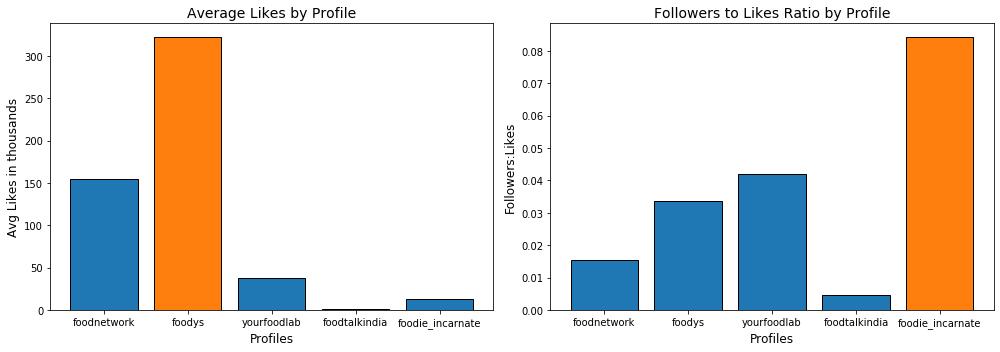

In [15]:
fig,ax = plt.subplots(1,2, figsize=(14,5))

colors = ['tab:blue' for i in range(5)]
colors[avg_likes.argmax()] = 'tab:orange'
ax[0].bar(top5handles,avg_likes/1000, edgecolor='k', color = colors)
ax[0].set_title("Average Likes by Profile",fontsize=14)
ax[0].set_xlabel("Profiles",fontsize=12)
ax[0].set_ylabel("Avg Likes in thousands",fontsize=12)

colors = ['tab:blue' for i in range(5)]
colors[flratio.argmax()]='tab:orange'
ax[1].bar(top5handles,flratio,edgecolor='k',color = colors)
ax[1].set_title("Followers to Likes Ratio by Profile",fontsize=14)
ax[1].set_xlabel("Profiles",fontsize=12)
ax[1].set_ylabel("Followers:Likes",fontsize=12)

plt.tight_layout()
plt.show()

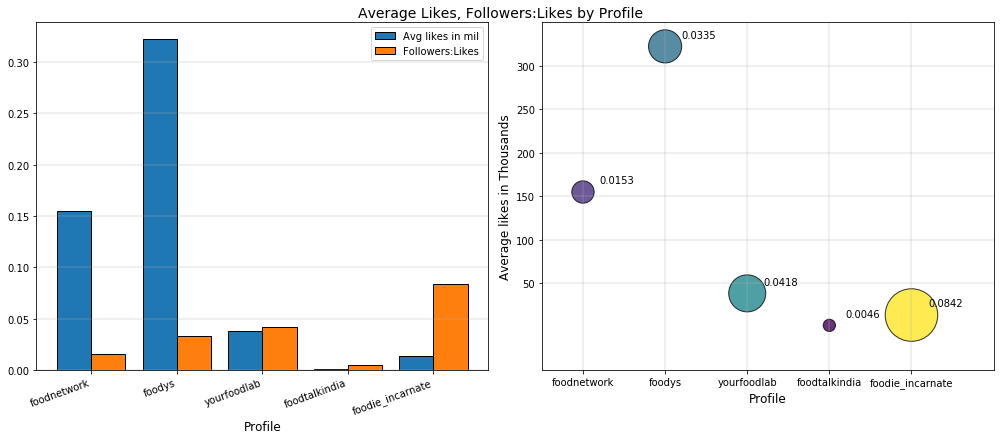

In [16]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
ax[0].bar(np.arange(0,5) - 0.4, avg_likes/1000000, width=0.4, align='center',edgecolor='k',label='Avg likes in mil')
ax[0].bar(top5handles,flratio, width=0.4, color='tab:orange', align='center',edgecolor='k',label='Followers:Likes')
ax[0].set_xticks(np.arange(5)-0.2)
ax[0].set_xticklabels(top5handles,rotation = 20,horizontalalignment='right')
# plt.yticks(np.arange(0,roundToN(max(y1),10),10))
ax[0].set_xlabel("Profile",fontsize=12)

ax[0].grid(axis='y',linewidth=0.4)

axes = plt.gca()
axes.yaxis.grid(linewidth=0.4)
ax[0].legend()
# colors = ['limegreen','crimson','aquamarine','deepviolet','gold']
# colors = ['crimson','darkslateblue','forestgreen','mediumseagreen','palevioletred']
ax[1].set_ylabel("Average likes in Thousands", fontsize = 12)
ax[1].set_yticks(np.arange(50,roundToN(max(avg_likes/1000)),50))
ax[1].set_xlabel("Profile",fontsize = 12)
ax[1].scatter(likes.keys(), avg_likes/1000 ,s = flratio*8**5, c = flratio, alpha=0.8, edgecolors='k')
for i in range(len(flratio)):
        ax[1].text(i+0.2,avg_likes[i]/1000+10,np.round(flratio[i],4))
ax[1].axis([-0.5,5,-50,roundToN(max(avg_likes/1000))])
ax[1].grid(linewidth=0.4)

plt.suptitle("Average Likes, Followers:Likes by Profile",fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
plt.tight_layout()
plt.show()